
# **Trader Behavior & Market Sentiment Analysis**
The goal of this analysis is to explore the relationship between trader performance (profitability, risk, volume, leverage) and market sentiment (Fear vs Greed). We aim to:

1.   Identify patterns in trader behavior under different sentiment conditions.
2.   Determine how profitability, risk, and trade volume vary across sentiments.
3. Detect clusters of trades and interpret their significance.
4. Provide actionable insights for smarter trading strategies.

In [11]:
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from google.colab import files

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)



**Data Overview**


---


[Trades dataset](https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view) has columns:





```
['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'time', 'date']
```





[Fear/Greed dataset ](https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view) has columns:


```
['timestamp', 'value', 'classification', 'date']
```

Data has been cleaned, normalized, and merged by date to align trades with market sentiment.

In [12]:
trades = pd.read_csv(f"https://drive.google.com/uc?id={"1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"}")
fear_greed = pd.read_csv(f"https://drive.google.com/uc?id={"1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"}")


def clean_columns(df):
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(' ', '_').replace('-', '_').replace('.', '') for c in df.columns]
    return df

trades = clean_columns(trades)
fear_greed = clean_columns(fear_greed)

# Convert numeric columns
num_cols = ['size_usd','size_tokens','closed_pnl','fee']
for col in num_cols:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')

# Standardize 'side'
trades['side'] = trades['side'].astype(str).str.lower().str.strip()

# Convert timestamps
trades['time'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')
trades['date'] = trades['time'].dt.floor('D')

fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce').dt.floor('D')

merged = trades.merge(fear_greed[['date','value','classification']], on='date', how='left')

merged['pnl_label'] = (merged['closed_pnl'] > 0).astype(int)

fg_summary = merged.groupby('classification').agg(
    avg_pnl=('closed_pnl','mean'),
    std_pnl=('closed_pnl','std'),
    total_pnl=('closed_pnl','sum'),
    total_volume=('size_usd','sum'),
    avg_volume=('size_usd','mean'),
    avg_leverage=('start_position','mean'),
    win_rate=('pnl_label', 'mean')
).reset_index()

print("Metrics by Sentiment:")
display(fg_summary)


Metrics by Sentiment:


,classification,avg_pnl,std_pnl,total_pnl,total_volume,avg_volume,avg_leverage,win_rate
0,Extreme Fear,1.891632,76.727713,4.399937e+03,9580240.04,4118.761840,21902.797505,0.292777
1,Extreme Greed,205.816345,1861.557119,1.156894e+06,18223760.27,3242.085086,24593.241160,0.553282
2,Fear,128.287950,1342.348497,1.779226e+06,79674391.06,5744.782685,8146.358518,0.381787
3,Greed,53.988003,1399.468182,6.096325e+05,57045815.74,5051.878829,37276.787811,0.435707
4,Neutral,27.088803,142.945889,7.465674e+04,11939551.21,4332.202906,89199.587406,0.494920


**Statistical Testing**


---



*T-test: Fear vs Greed PnL*


`t = 4.266, p ≈ 0.000`

**Interpretation:**

The difference in PnL between Fear and Greed periods is statistically significant.

> **Traders earn higher PnL on average during Fear periods compared to Greed.**

In [13]:
fear_pnl = merged.loc[merged['classification'].str.lower()=='fear','closed_pnl'].dropna()
greed_pnl = merged.loc[merged['classification'].str.lower()=='greed','closed_pnl'].dropna()

t_stat, p_val = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"T-test Fear vs Greed PnL: t={t_stat:.3f}, p={p_val:.4f}")

T-test Fear vs Greed PnL: t=4.266, p=0.0000


**Clustering Trades**


---


*KMeans clustering (3 clusters) was applied using:*

`['size_usd' , 'closed_pnl' , 'fee']`

*Insights:*

> Retail traders (Cluster 0) dominate small trades across all sentiments.

>Medium-large traders (Cluster 1) profit most in Extreme Greed.

> Very-large traders (Cluster 2) make very large profitable trades, usually during Fear or Greed.


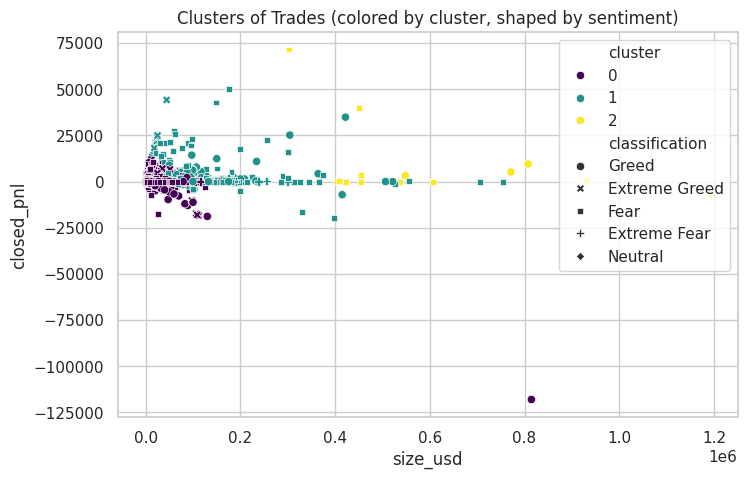

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Accuracy (time-series CV): 0.5423701852062266


In [19]:
cluster_features = ['size_usd','closed_pnl','fee']
X_cluster = merged[cluster_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_scaled)

# Scatter plot of clusters
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged, x='size_usd', y='closed_pnl', hue='cluster', palette='viridis', style='classification')
plt.title("Clusters of Trades (colored by cluster, shaped by sentiment)")
plt.savefig("cluster_trade_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()
# files.download("cluster_trade_sentiment.png")

features = ['size_usd','fee','value']
X = merged[features].fillna(0)
y = merged['pnl_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='accuracy')
print("Random Forest Accuracy (time-series CV):", scores.mean())

**Visualizations**


---



1. Average PnL by Sentiment

2. Total Trade Volume by Sentiment

3. Win Rate by Sentiment

4. Clusters of Trades (scatterplot with sentiment overlay)

In [16]:
cluster_summary = merged.groupby('cluster').agg(
    avg_size=('size_usd','mean'),
    median_size=('size_usd','median'),
    avg_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    avg_fee=('fee','mean'),
    median_fee=('fee','median'),
    avg_leverage=('start_position','mean'),
    median_leverage=('start_position','median'),
    count=('size_usd','count')
).reset_index()

print("Cluster Overview:")
display(cluster_summary)

cluster_sentiment = merged.groupby(['cluster','classification']).agg(
    avg_pnl=('closed_pnl','mean'),
    avg_size=('size_usd','mean'),
    avg_leverage=('start_position','mean'),
    count=('size_usd','count')
).reset_index()

print("Cluster behavior across Sentiments:")
display(cluster_sentiment)


Cluster Overview:


,cluster,avg_size,median_size,avg_pnl,median_pnl,avg_fee,median_fee,avg_leverage,median_leverage,count
0,0,3237.032764,581.620,29.080838,0.000000,0.665089,0.087221,-30479.969547,102.211200,208369
1,1,143986.871232,108655.505,1218.572297,0.000000,31.980930,26.421278,9354.804405,7.443715,2720
2,2,926265.723185,618900.170,6836.274733,295.599175,150.264212,139.498439,1994.382639,14.454770,135


Cluster behavior across Sentiments:


,cluster,classification,avg_pnl,avg_size,avg_leverage,count
0,0,Extreme Fear,0.241867,3023.722858,22031.896614,2306
1,0,Extreme Greed,94.074053,2966.147728,24298.563851,5581
2,0,Fear,77.783121,3681.323444,8119.139628,13688
3,0,Greed,21.209744,3770.977226,37115.367213,11187
4,0,Neutral,23.556266,3952.748585,89589.521616,2743
5,1,Extreme Fear,192.109566,130376.756500,7017.670245,20
6,1,Extreme Greed,15796.659610,41742.245000,65708.092642,40
7,1,Fear,3609.035343,135861.968750,11018.838561,168
8,1,Greed,3510.066474,116845.094257,56267.493959,101
9,1,Neutral,772.454095,84397.064615,6923.469110,13


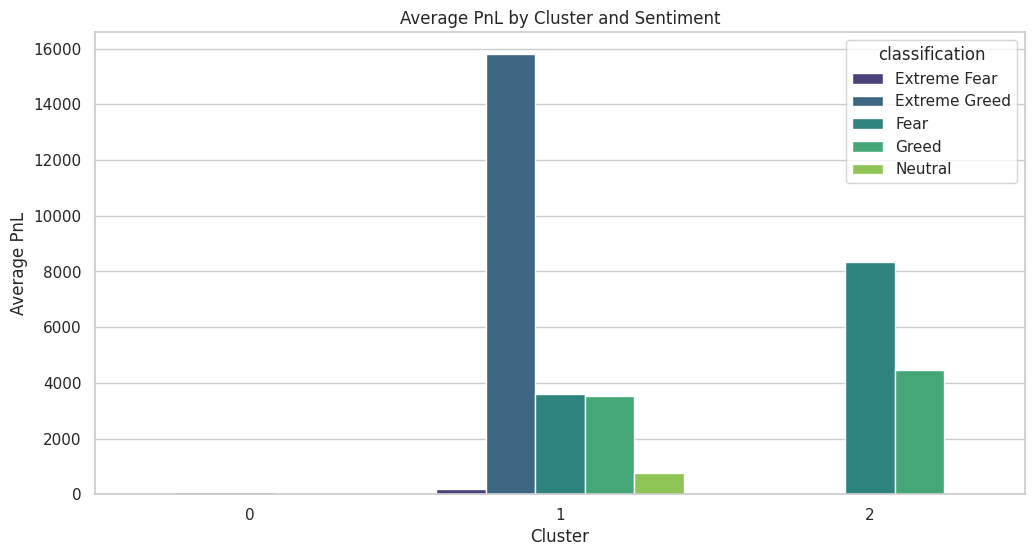

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

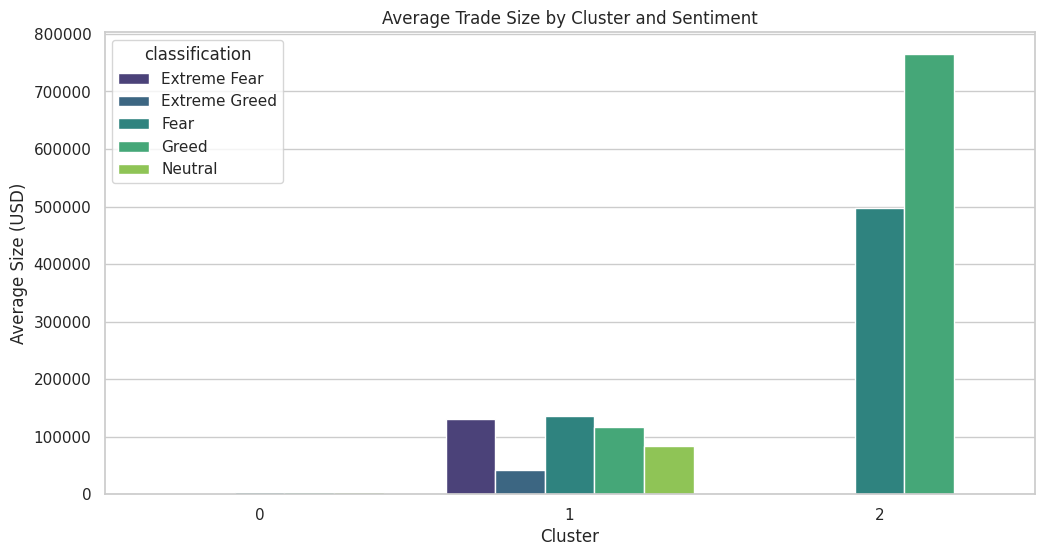

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

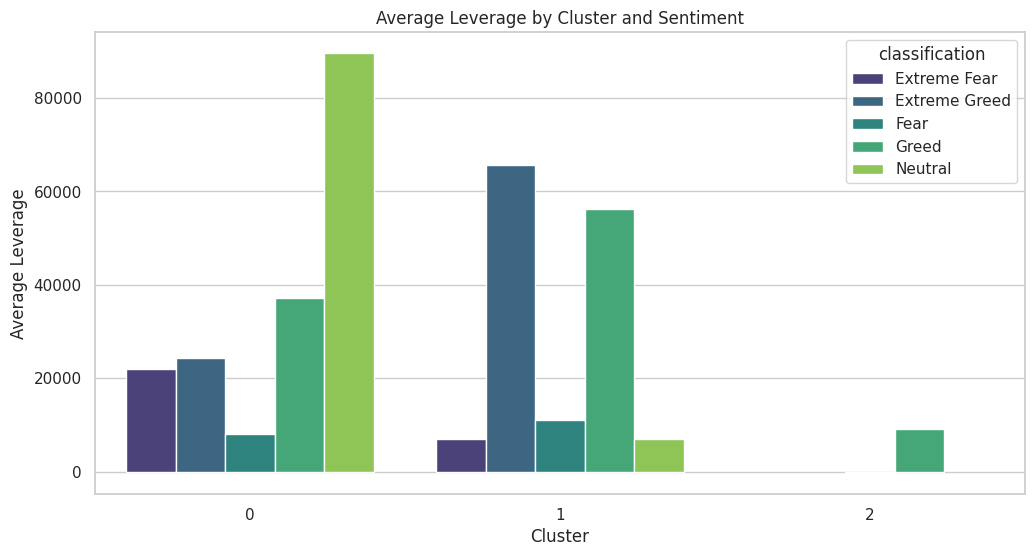

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

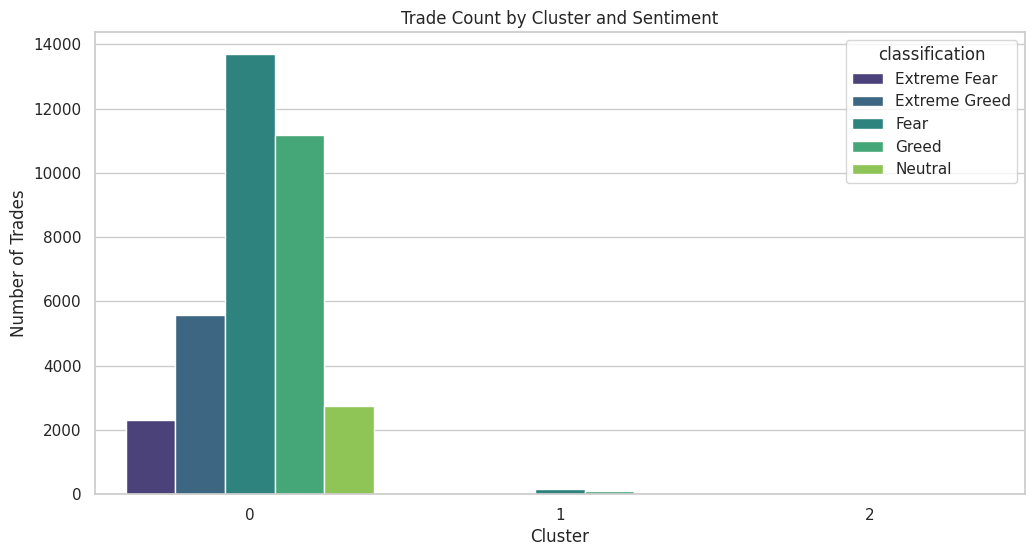

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:


# Average PnL by Cluster and Sentiment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_sentiment, x='cluster', y='avg_pnl', hue='classification', palette='viridis')
plt.title("Average PnL by Cluster and Sentiment")
plt.ylabel("Average PnL")
plt.xlabel("Cluster")
plt.savefig("avg_pnl_by_cluster_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()
# files.download("avg_pnl_by_cluster_sentiment.png")


# Average Size by Cluster and Sentiment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_sentiment, x='cluster', y='avg_size', hue='classification', palette='viridis')
plt.title("Average Trade Size by Cluster and Sentiment")
plt.ylabel("Average Size (USD)")
plt.xlabel("Cluster")
plt.savefig("avg_size_by_cluster_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()
# files.download("avg_size_by_cluster_sentiment.png")


# Average Leverage by Cluster and Sentiment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_sentiment, x='cluster', y='avg_leverage', hue='classification', palette='viridis')
plt.title("Average Leverage by Cluster and Sentiment")
plt.ylabel("Average Leverage")
plt.xlabel("Cluster")
plt.savefig("avg_leverage_by_cluster_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()
# files.download("avg_leverage_by_cluster_sentiment.png")

# Count of Trades by Cluster and Sentiment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_sentiment, x='cluster', y='count', hue='classification', palette='viridis')
plt.title("Trade Count by Cluster and Sentiment")
plt.ylabel("Number of Trades")
plt.xlabel("Cluster")
plt.savefig("trade_count_by_cluster_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()
# files.download("trade_count_by_cluster_sentiment.png")


In [17]:
# dataframes = {
#     "merged": merged,
#     "fear_greed": fear_greed,
#     "cluster_summary": cluster_summary
# }

# from google.colab import files

# for name, df in dataframes.items():
#     file_name = f"{name}.csv"
#     df.to_csv(file_name, index=False)
#     files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Key Insights for Trading Strategy**


---



1. Profitability aligns with strong sentiment:
```
  Fear → high-risk/high-reward trades
  Greed → moderate-risk profitable trades.
```

2. Risk management is critical :
*  Retail traders with high leverage risk losses in extreme sentiment periods.

3. Actionable strategy:

*   Exploit Fear periods carefully with calculated risk.
*   Use Greed periods for moderate, safer trades.
*   Whale/large-trade signals can inform liquidity opportunities.